# **Khởi tạo**

**Import thư viện**

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_absolute_error
import os

**Xử lý dữ liệu**

In [82]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    # Tiền xử lý các cột khác nếu cần thiết

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    data = data.reset_index()['Price']

    return data

**Xây dựng mô hình**

In [83]:
# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [84]:
def RNN_prediction(name, file_name, train_ratio=0.7, test_ratio=0.2, forecast_days=30):
    # Đọc dữ liệu từ file CSV
    data = read_file(file_name)

    # Scaler data
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(np.array(data).reshape(-1,1))

    # Chia train, test
    train_size = int(train_ratio * len(data))
    test_size = int(test_ratio * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]

    # Hàm Create Dataset
    def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)
    
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define RNN Model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Đánh giá độ chính xác thuật toán bằng RMSE
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Testing RMSE:', test_rmse)

    # Đánh giá độ chính xác thuật toán bằng MAE
    test_mae = mean_absolute_error(y_test, y_pred)
    print('Testing MAE:', test_mae)
    
    # Đánh giá độ chính xác thuật toán bằng MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print('Testing MAPE:', test_mape)
    
    # Dự báo n ngày tiếp theo
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < forecast_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())

    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    
    # Vẽ hình
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, y_pred)
    predict_data_index = pd.RangeIndex(start=len(data), stop=len(data)+forecast_days, step=1)
    plt.plot(predict_data_index, scaler.inverse_transform(lst_output))
    plt.legend(['Train', 'Test', 'Predict', f'Predict {forecast_days} days'])
    plt.show()
    

# **BIDV**

## **30 ngày**

**BIDV 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 0.17210976086829652
Testing MAE: 0.02088667888783231
Testing MAPE: 19.96189630710594


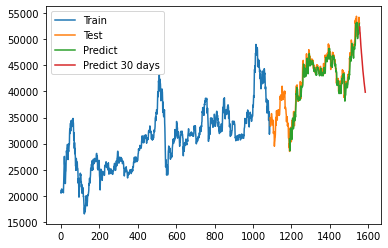

In [85]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**BIDV 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Testing RMSE: 0.13094904443184965
Testing MAE: 0.016511408799009853
Testing MAPE: 13.557959815888104


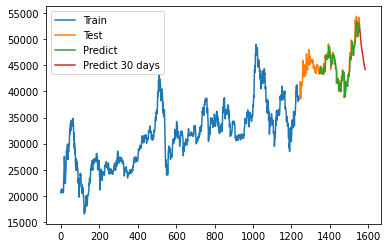

In [86]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**BIDV 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Testing RMSE: 0.10660404794885121
Testing MAE: 0.02018331813911631
Testing MAPE: 9.852203785251326


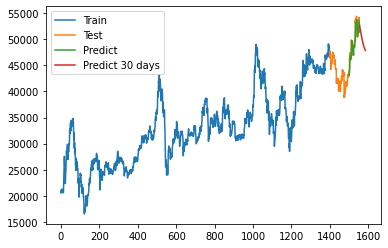

In [87]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**BIDV 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 0.17224519915498152
Testing MAE: 0.02349135181626922
Testing MAPE: 19.934107187996545


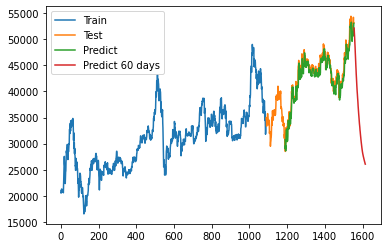

In [88]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**BIDV 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.1317881341225399
Testing MAE: 0.017039052066648255
Testing MAPE: 13.60590250048321


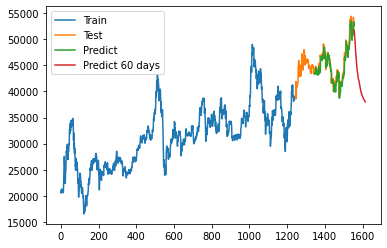

In [89]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**BIDV 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 0.10702443166418116
Testing MAE: 0.021630018669729762
Testing MAPE: 9.884850256662343


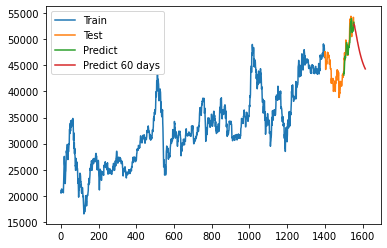

In [90]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**BIDV 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing RMSE: 0.17248393927315692
Testing MAE: 0.01665412427123288
Testing MAPE: 20.154617970477943


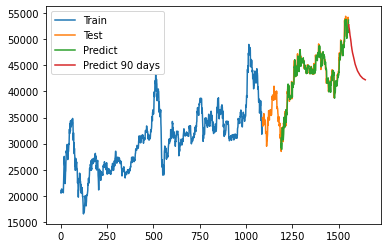

In [91]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**BIDV 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Testing RMSE: 0.1311459655523021
Testing MAE: 0.02853332086912097
Testing MAPE: 13.412676556141564


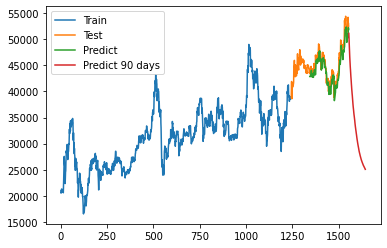

In [92]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**BIDV 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 
Testing RMSE: 0.10747133590821563
Testing MAE: 0.025504070219229905
Testing MAPE: 9.904653708835935


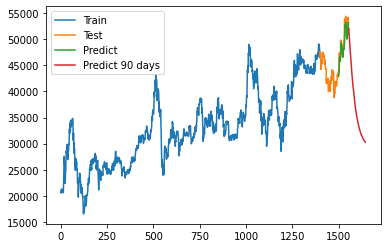

In [93]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **MBB**

## **30 ngày**

**MBB 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Testing RMSE: 0.12880581662576315
Testing MAE: 0.015415427553281008
Testing MAPE: 16.732850320706817


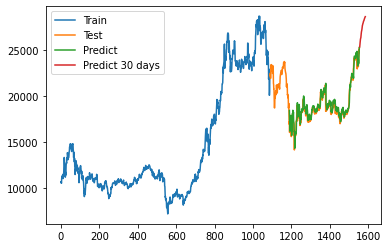

In [94]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**MBB 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Testing RMSE: 0.13679457613771084
Testing MAE: 0.012044602163983014
Testing MAPE: 17.01288757227592


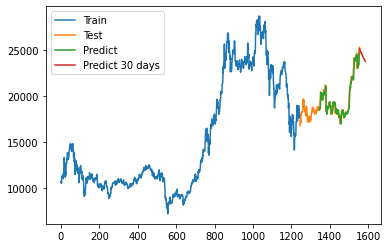

In [95]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**MBB 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
Testing RMSE: 0.09519051418562838
Testing MAE: 0.013868216540885577
Testing MAPE: 10.580277533640436


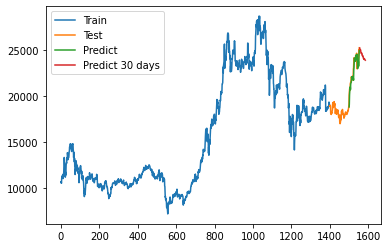

In [96]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**MBB 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Testing RMSE: 0.1275104029411563
Testing MAE: 0.016340049917695398
Testing MAPE: 16.527622593569184


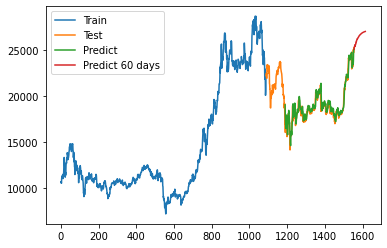

In [97]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**MBB 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.13773813308153693
Testing MAE: 0.0109167988753198
Testing MAPE: 17.195612850008164


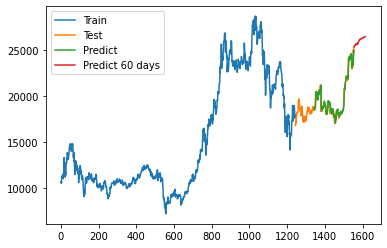

In [98]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**MBB 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 0.09712596844931903
Testing MAE: 0.021304580620168427
Testing MAPE: 10.70032069974712


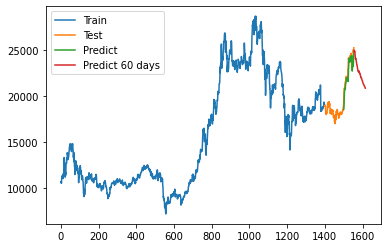

In [99]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**MBB 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing RMSE: 0.12751949537846097
Testing MAE: 0.013769587389214967
Testing MAPE: 16.458671308176033


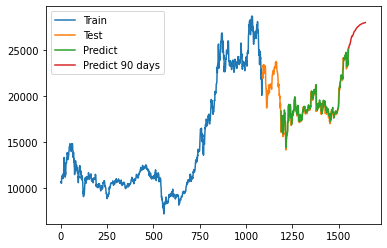

In [100]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**MBB 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Testing RMSE: 0.13722243221547123
Testing MAE: 0.012148587173261156
Testing MAPE: 17.042908989115904


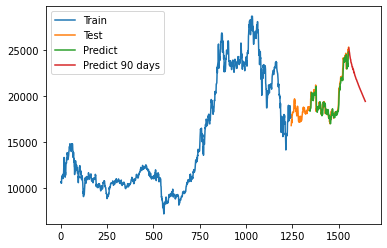

In [101]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**MBB 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Testing RMSE: 0.09628285078165123
Testing MAE: 0.02058721025059608
Testing MAPE: 10.629209078938345


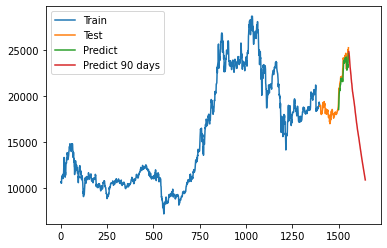

In [102]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **VCB**

## **30 ngày**

**VCB 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Testing RMSE: 0.15546183553060286
Testing MAE: 0.02235697626019223
Testing MAPE: 17.103215714426504


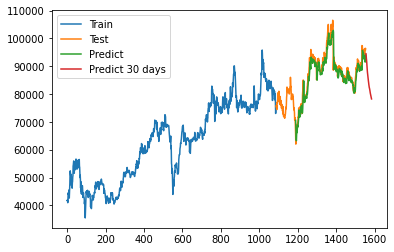

In [103]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**VCB 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.11729478680095161
Testing MAE: 0.015024765989488818
Testing MAPE: 11.526939215723123


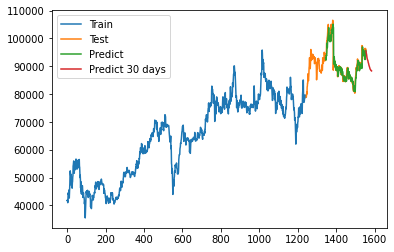

In [104]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**VCB 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
Testing RMSE: 0.062306977881258954
Testing MAE: 0.012908913989193624
Testing MAPE: 6.228210615691718


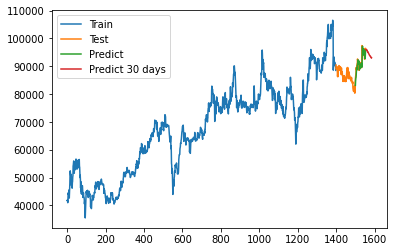

In [105]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**VCB 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 0.15682295369514115
Testing MAE: 0.023039812982962166
Testing MAPE: 17.239949191664607


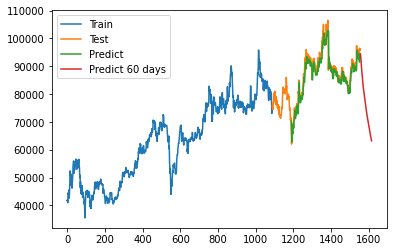

In [106]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**VCB 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.1160893904003257
Testing MAE: 0.016260307686203488
Testing MAPE: 11.403325390452256


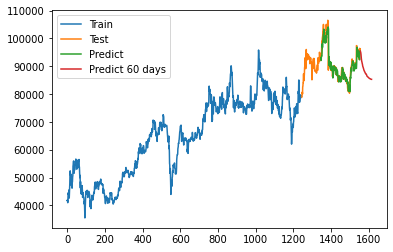

In [107]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**VCB 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Testing RMSE: 0.06271840725596399
Testing MAE: 0.014987540971166604
Testing MAPE: 6.238366676158493


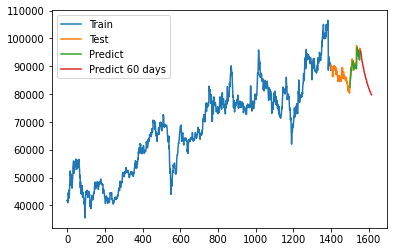

In [108]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**VCB 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Testing RMSE: 0.15591697563970816
Testing MAE: 0.017635561609245638
Testing MAPE: 17.24294966431143


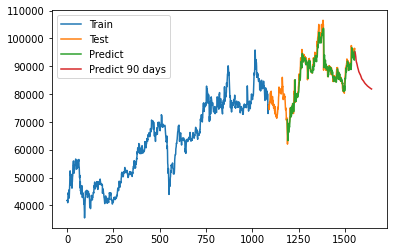

In [109]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**VCB 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Testing RMSE: 0.11584368693076856
Testing MAE: 0.03147303111117924
Testing MAPE: 11.229451698795542


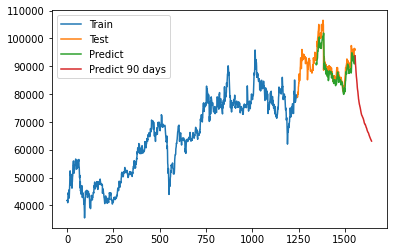

In [110]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**VCB 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step 
Testing RMSE: 0.061719791848274946
Testing MAE: 0.013727307354985015
Testing MAPE: 6.161612782166001


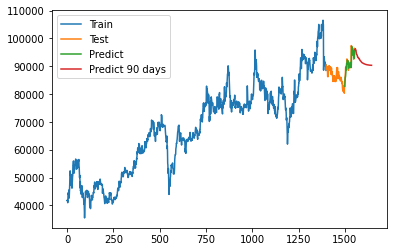

In [111]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)